### CNN_mnist

### Import

In [11]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.init

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
### GPU설정 / ramdom seed설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available(), "→", device)

### seed 
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

True → cuda


### Parameter

In [22]:
# parameter
learning_rate = 0.001
training_epochs = 10
batch_size = 100

### Download Dataset

In [23]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train = True,
                          transform=transforms.ToTensor(), # 텐서값으로 변환
                          download=True ) # 다운로드

mnist_test = dsets.MNIST(root='MNIST_data/',
                          train = False, # 테스트 셋
                          transform=transforms.ToTensor(), # 텐서값으로 변환
                          download=True ) # 다운로드

### 데이터 정보 & 샘플 확인

In [24]:
print("데이터 타입: ", type(mnist_train))
print("훈련데이터:", mnist_train.train_data.shape)
print("테스트데이터:", mnist_test.test_data.shape)
print("라벨 예시 : ", mnist_test.test_labels)

데이터 타입:  torchvision.datasets.mnist.MNIST
훈련데이터: torch.Size([60000, 28, 28])
테스트데이터: torch.Size([10000, 28, 28])
라벨 예시 :  tensor([7, 2, 1,  ..., 4, 5, 6])


이미지 크기 :  torch.Size([28, 28])
라벨 :  tensor(5)


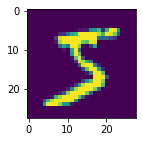

In [34]:
sample = mnist_train.train_data[0]

print("이미지 크기 : ", sample.shape)
print("라벨 : ", mnist_train.train_labels[0])
plt.figure(figsize=(2,2))
plt.imshow(sample)

### Data Loader 활용

In [26]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

### 네트워크 모델 Class 구성

In [54]:
# CNN Model (2 conv layers)
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()                                                                               #(b,   1, 28, 28) input

        self.conv_layer1 = torch.nn.Sequential(                                                       #      [32] 채널→필터의 갯수→32개 특징 Feature Map 생성
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),            #(b,  32, 28, 28) conv2d   
            torch.nn.ReLU(),                                                                                           
            torch.nn.MaxPool2d(kernel_size=2, stride=2))                                      #(b,  32, 14, 14) pool     

        self.conv_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),         #(b,  64, 14, 14) conv2d
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))                                     #(b,  64,  7,    7) pool

        self.fc = torch.nn.Linear(64*7*7, 10, bias=True)                                      # (in, out) → 연산 →  (out)   cf. TF의 Dense Layer 
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [55]:
# 모델생성
model = CNN().to(device)
model

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

### Optimizer , Cost Function

In [56]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [58]:
total_batch = len(data_loader)
print('total_batch : ', total_batch)

for epoch in range(training_epochs):
    avg_cost = 0
    
    for i, (X, Y) in enumerate(data_loader): # X : 이미지, Y:  라벨
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        
        cost = criterion(hypothesis, Y)     

        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    
    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))        
print('Learning Finished!')
print('data_loader loop : ', i)

total_batch :  600
[Epoch:1] cost = 0.010913464240729809
[Epoch:2] cost = 0.009663457982242107
[Epoch:3] cost = 0.008434436284005642
[Epoch:4] cost = 0.006289784796535969
[Epoch:5] cost = 0.006862747948616743
[Epoch:6] cost = 0.00502881221473217
[Epoch:7] cost = 0.004879379644989967
[Epoch:8] cost = 0.0038572067860513926
[Epoch:9] cost = 0.0051856799982488155
[Epoch:10] cost = 0.003909363877028227
Learning Finished!
data_loader loop :  599


### Test

In [64]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)
    print(X_test.shape)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

torch.Size([10000, 1, 28, 28])
Accuracy: 0.9855999946594238
